# 08 MNIST experiment
An experiment consisting of such steps:
1. Create a toy MNIST problem classifying only between 0 and 8.
2. Train a CNN classifier on the data
3. generate an attribution map of the classifier (should focus somewhere to the center)
4. Check if the attribution maps are correct. If false, use RRR to fix them.

The main goal of this experiment is to smoothly introduce usage of RRR as well as show usefulness of the algorithm

## 1.1 Dataset preparation

In [12]:
%matplotlib inline
import numpy
import torchvision.datasets as tds
from torchvision.transforms import ToTensor, Lambda
import torch

num_classes = 2

ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1 if y == 8 else 2), value=1)) 
)

# target transformation according to "output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 8)"
ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1 if y == 8 else 2), value=1))
)

train_dataset_length = 200

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.34MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 256kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.94MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.38MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Length of ds_train: 200; length of ds_test: 1954
shape of x[0]: torch.Size([1, 28, 28])
y[0]: tensor([1., 0.])


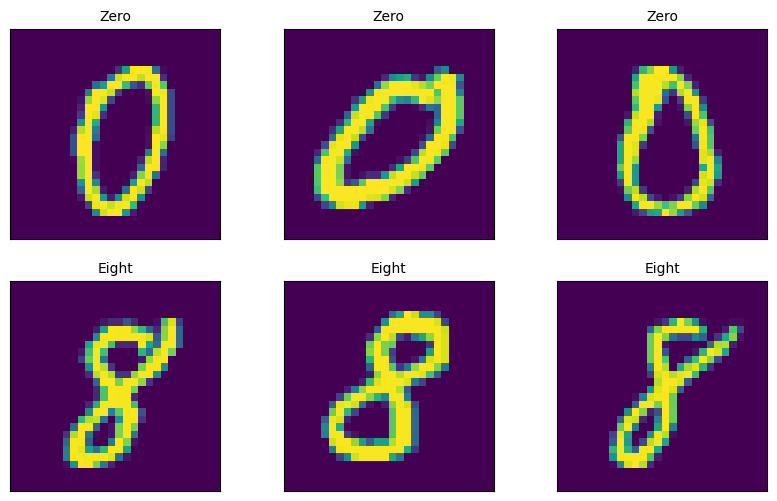

In [13]:
print(f"Length of ds_train: {len(ds_train)}; length of ds_test: {len(ds_test)}")
first = ds_train[0]
first_x = first[0]
print("shape of x[0]:", first_x.shape)
print("y[0]:", first[1])
size_1_dim = first_x.shape[1] * first_x.shape[2]

import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# fig.subplots_adjust(wspace=0, hspace=0)

# Show 3 instances for each of the 2 labels
label_translation = dict(zero=torch.tensor((1, 0)), eight=torch.tensor((0, 1)))
zeros = []
eights = []
example_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=1, shuffle=True)
for i, (X, y) in enumerate(example_dataloader):
    X = torch.flatten(X, 0, 2)
    if all(y[0] == label_translation["zero"]) and len(zeros) != 3:
        zeros.append(X)
    elif all(y[0] == label_translation["eight"]) and len(eights) != 3:
        eights.append(X)
    
    if len(zeros) == 3 and len(eights) == 3:
        break
    
for i, X in enumerate(zeros):
    ax_list[0][i].imshow(X, cmap='viridis')
    ax_list[0][i].set_title("Zero", fontsize=10, color='black')
    ax_list[0][i].set_xticks([])
    ax_list[0][i].set_yticks([])
    # ax_list[0][i].set_facecolor('black')

for i, X in enumerate(eights):
    ax_list[1][i].imshow(X, cmap='viridis')
    ax_list[1][i].set_title("Eight", fontsize=10, color='black')
    ax_list[1][i].set_xticks([])
    ax_list[1][i].set_yticks([])
    # ax_list[1][i].set_facecolor('black')

## 1.2 CNN definition

In [42]:
from torch.nn import Sequential, Conv2d, MaxPool2d, Flatten, ReLU, Linear, Dropout, Softmax

# input: 28X28 images
# output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 1)

model = Sequential(
    # 1st group
    Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, return_indices=False), #return_indices=True is apparently needed to compute second-order derivatives
    # 2nd group
    Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, return_indices=False),
    # TODO: maybe 3rd group
    # Flattening into 1d array
    Flatten(),
    # Dense layers (aka Fully-connected layers)
    Linear(in_features=32 * 7 * 7, out_features=128), # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
    ReLU(),
    Linear(in_features=128, out_features=num_classes),
    Softmax(dim=1)
)
# model.eval()
def reset_parameters(model):
    for layer in model:
        try:
            layer.reset_parameters()
        except AttributeError:
            print(f"layer of type {type(layer)} does not have function `reset_parameters")



In [17]:
from torch.utils.data import DataLoader
from src.utils import XILUtils
t_dl = DataLoader(ds_train, batch_size=4)
device = XILUtils.define_device()
print(device)
test_model = model.to(device)
for batch, (X, y) in enumerate(t_dl):
    X = X.to(device)
    y = y.to(device)
    print(X.device, y.device)
    print(X, y)
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    test_model.eval()
    output = test_model(X)
    print(output.shape)
    print(output)
    break

mps
mps:0 mps:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

## 1.3 Training on MNIST dataset


In [18]:
import torch.nn.functional as F
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # move X, y to device
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (F.one_hot(pred.argmax(1), num_classes=num_classes) == y).type(torch.float).sum().item() / num_classes

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [52]:
from src.utils import XILUtils, ModelConfig
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import torch.nn as nn

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

# TODO: Try out both Adam and SGD
lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
sgd_opt = SGD(model.parameters(), lr=lr, momentum=0.9)
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
#   data imbalance prevention
# class_weights = torch.tensor([0.02, 0.45, 0.45], dtype=torch.float32).to(device)
loss = nn.CrossEntropyLoss()

# create dataloader
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

# model config
conf = ModelConfig(batch_size=batch_size)


epochs = 10

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")
    
    # train loop 
    XILUtils.train_loop(train_dataloader, model, loss_fn=loss, optimizer=adam_opt, model_config=conf, device=device)
    
    # Evaluate the model
    test_loop(test_dataloader, model, loss_fn=loss, device=device)

print("Done!")


Epoch 1
--------------------
loss: 0.436943 [   64/  200]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.462952 

Epoch 2
--------------------
loss: 0.484156 [   64/  200]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.412938 

Epoch 3
--------------------
loss: 0.393194 [   64/  200]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.426062 

Epoch 4
--------------------
loss: 0.369191 [   64/  200]
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.387812 

Epoch 5
--------------------
loss: 0.358987 [   64/  200]
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.360914 

Epoch 6
--------------------
loss: 0.355458 [   64/  200]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.355241 

Epoch 7
--------------------
loss: 0.362916 [   64/  200]
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.351781 

Epoch 8
--------------------
loss: 0.334117 [   64/  200]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.362421 

Epoch 9
--------------------
loss: 0.326683 [   64/  200]
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.363223 

Epoch 10
-

## 1.4 Applying grad-cam

In [7]:
# params = model.parameters
# print(params)
# model.eval()

# layers = [model[3]]
# for layer in layers:
#     layer
# 


Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 99.997% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 99.871% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 99.998% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 99.064% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 59.968% certainty. Correct? True


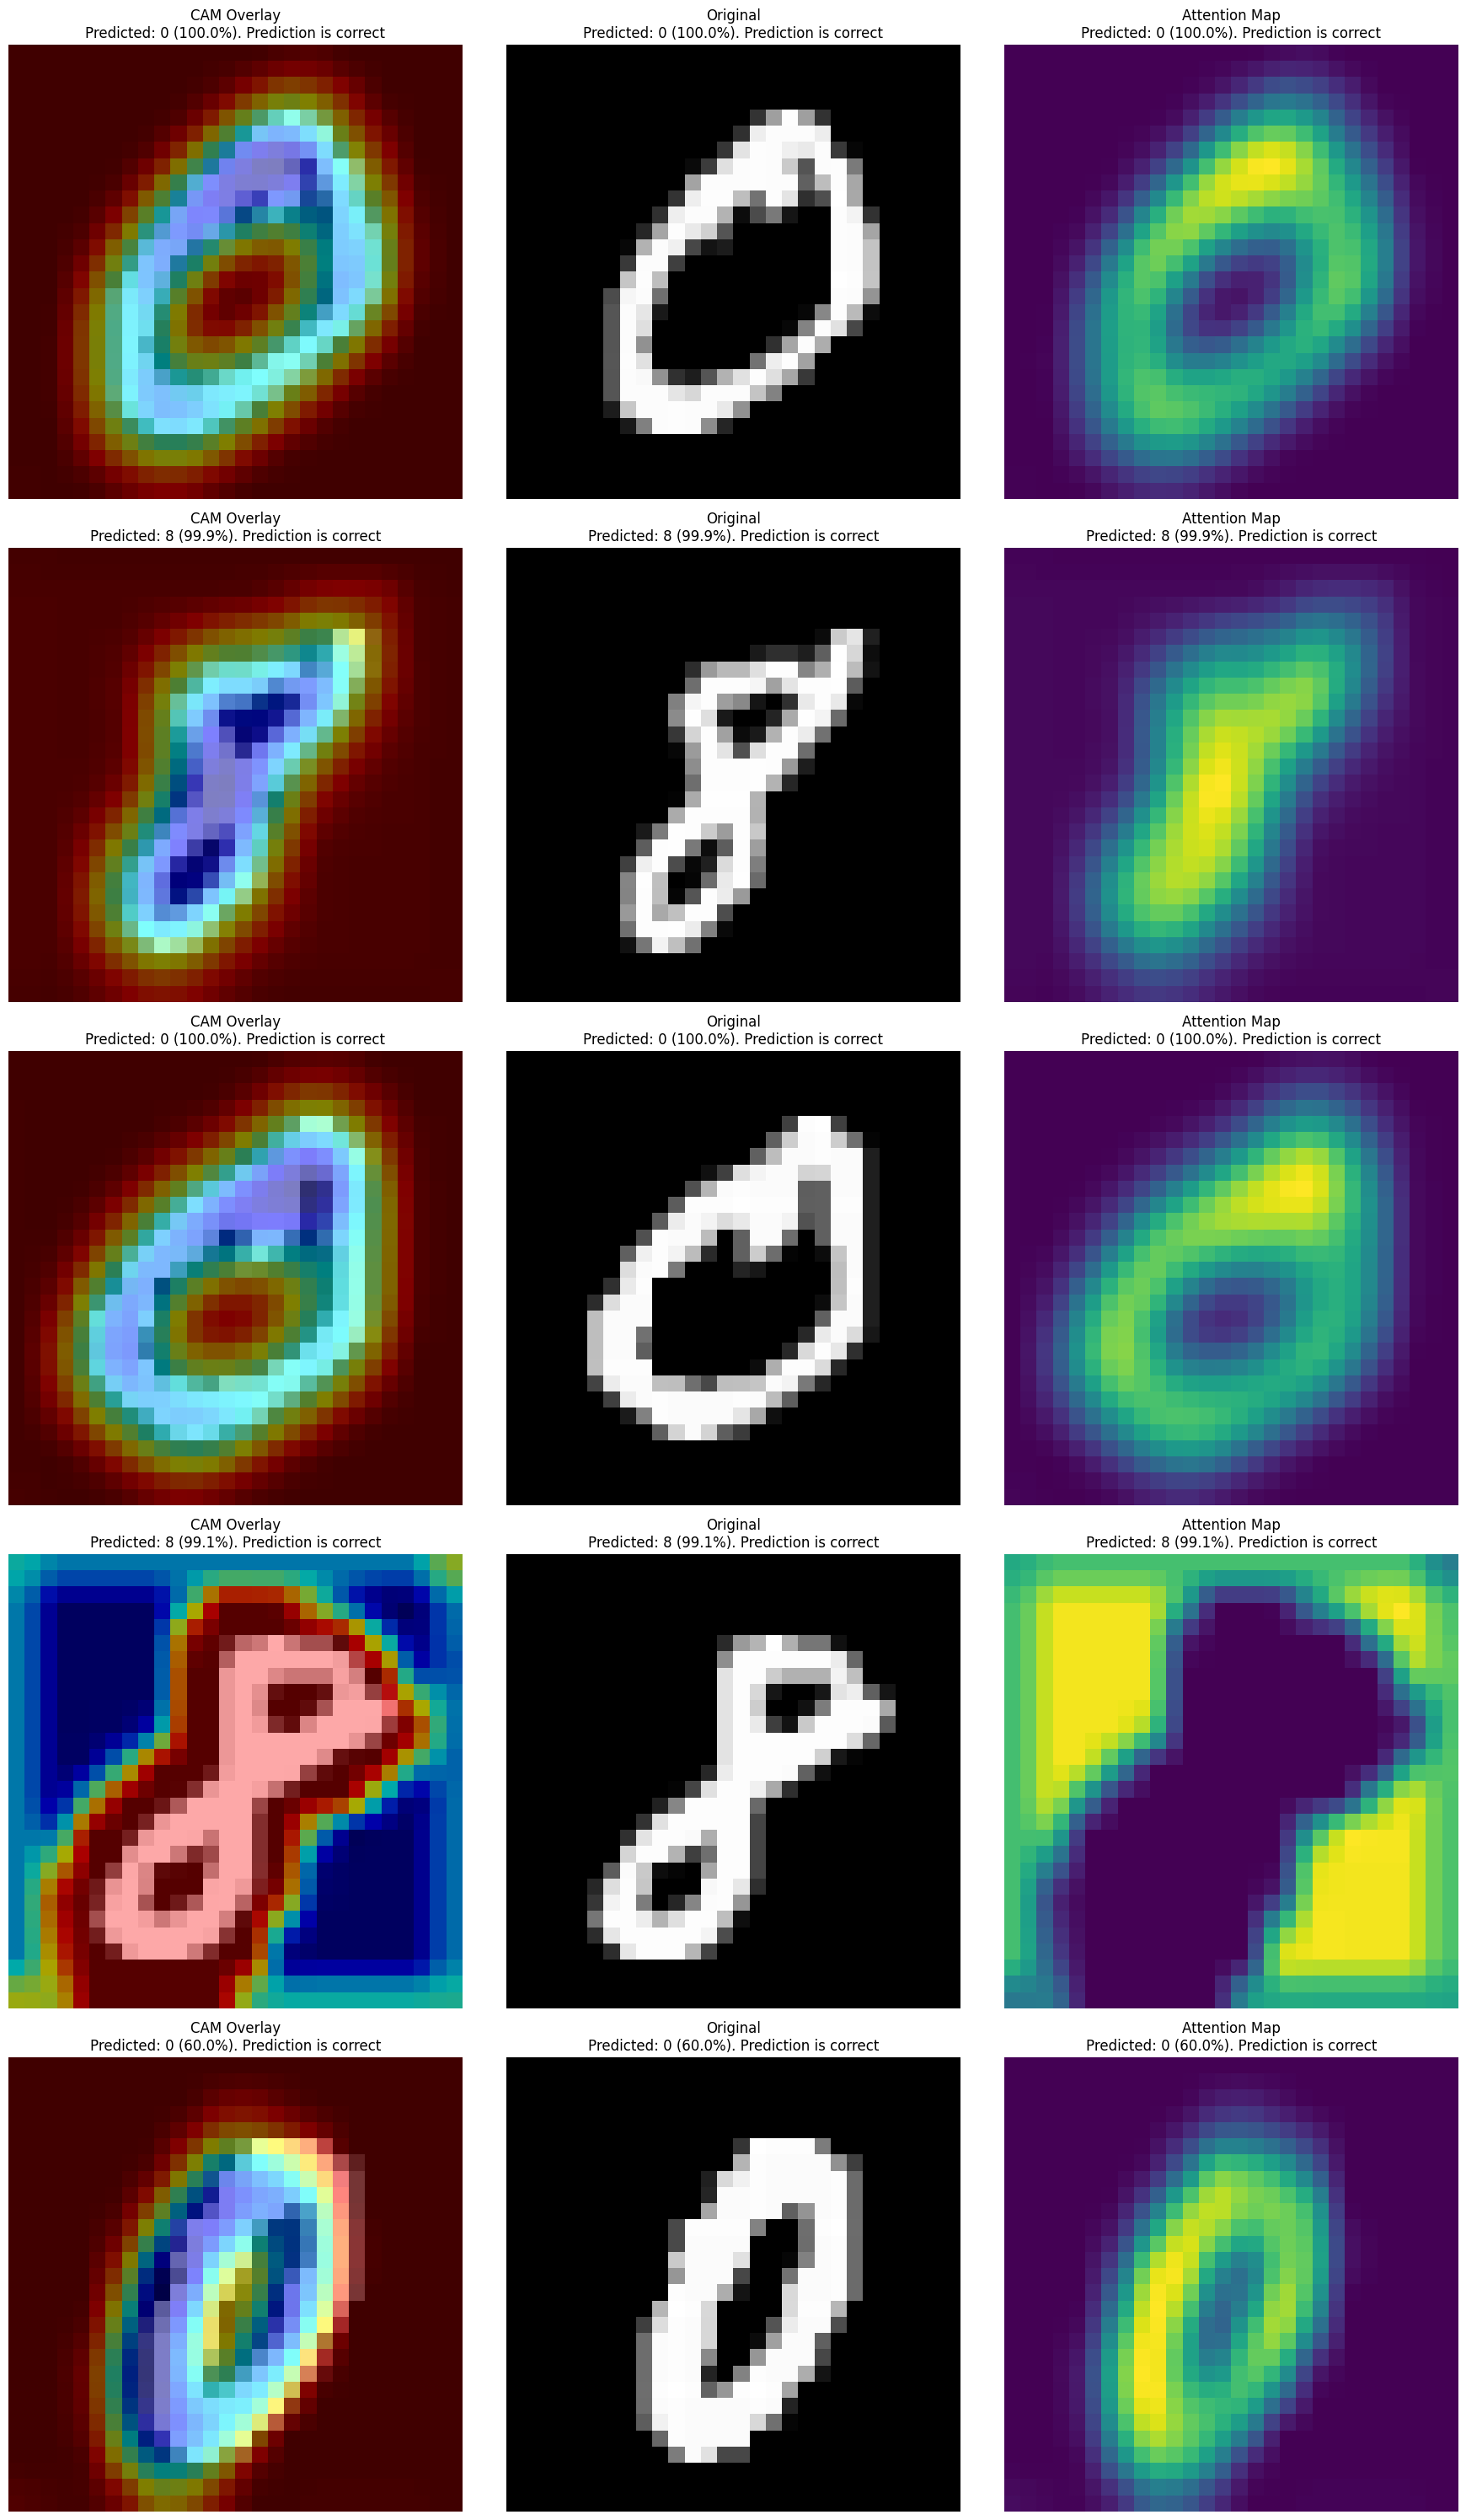

In [53]:
# Second version of gradcam application
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np


# define model
# model
# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3] # TODO
target_layers = [last_conv_layer]

# Number of examples to show
n_examples = 5  # you can change this number

# define input tensor
gradcam_dataloader = DataLoader(ds_train, batch_size=n_examples, shuffle=False)
dataloader_iterator = iter(gradcam_dataloader)
batch = next(dataloader_iterator)
examples = batch[0]
targets = batch[1]

# Process all examples
images = []
cam_images = []
grayscale_maps = []
predictions = []
certainties = []
is_correct = []

model.eval()
for index in range(n_examples):
    
    example = examples[index]
    target = targets[index]
    
    # Get prediction
    prediction_probs = model(example.unsqueeze(0).to(device))
    prediction = torch.zeros(num_classes)
    prediction[prediction_probs.argmax()] = 1
    certainty = prediction_probs.max().item() * 100
    
    predictions.append(prediction_probs.argmax().item())
    certainties.append(certainty)
    is_correct.append(all(prediction == target))
    
    print(f"\nExample {index}:")
    print(f"Shape of example: {example.shape}")
    print(f"Target of example: {target}")
    print(f"Predicted target: {prediction} with {certainty:.3f}% certainty. Correct? {all(prediction == target)}")

    # Prepare image
    img: numpy.ndarray = example.reshape((28, 28, 1)).repeat(1, 1, 3).numpy()
    images.append(img)

    # Generate GradCAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=example.unsqueeze(0), targets=None, aug_smooth=None, eigen_smooth=None)
        grayscale_cam = grayscale_cam[0, :]
        grayscale_maps.append(grayscale_cam)
        
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=False)
        cam_images.append(cam_image)

# Plot all examples
fig, axes = plt.subplots(n_examples, 3, figsize=(18, 6*n_examples))
if n_examples == 1:
    axes = axes.reshape(1, -1)

for idx in range(n_examples):
    # Create title with prediction and certainty
    pred_title = f'Predicted: {labels[predictions[idx]]} ({certainties[idx]:.1f}%). Prediction is {"" if is_correct[idx] else "NOT "}correct'
    
    # First subplot: CAM Overlay
    axes[idx, 0].imshow(cam_images[idx], cmap='viridis')
    axes[idx, 0].set_title(f'CAM Overlay\n{pred_title}')
    axes[idx, 0].axis('off')
    
    # Second subplot: Original Image
    axes[idx, 1].imshow(images[idx], cmap='viridis')
    axes[idx, 1].set_title(f'Original\n{pred_title}')
    axes[idx, 1].axis('off')
    
    # Third subplot: Attention Map
    axes[idx, 2].imshow(grayscale_maps[idx])
    axes[idx, 2].set_title(f'Attention Map\n{pred_title}')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# 1.5 Save model weights and other data 

In [8]:
from pathlib import Path
DIR = Path("08_MNIST_output/")
SUBEXPERIMENT_NUM = "04_" # TODO replace with actual
PREFIX = f"exp_{SUBEXPERIMENT_NUM}_" 

In [9]:
# Save model weights
EXTENSION = ".pth"
weights_filename = PREFIX + "weights" + EXTENSION
torch.save(model.state_dict(), DIR / weights_filename)

In [10]:
# Save the figures
pic_name = (PREFIX + "result.png")
fig.savefig(DIR / pic_name)

In [11]:
# Create md file with details on current subexperiment

# Define the content of the Markdown file
model_architecture = f"""
```python
from torch.nn import Sequential, Conv2d, MaxPool2d, Flatten, ReLU, Linear, Dropout, Softmax

# input: 28X28 images
# output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 1)

model = Sequential(
    # 1st group
    Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # 2nd group
    Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # TODO: maybe 3rd group
    # Flattening into 1d array
    Flatten(),
    # Dense layers (aka Fully-connected layers)
    Linear(in_features=32 * 7 * 7, out_features=128), # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
    ReLU(),
    Linear(in_features=128, out_features=num_classes),
    Softmax(dim=1)
)
```
"""

training_description = f"""
- Training data: Length of ds_train: 200; length of ds_test: 1954
- ADAM optimizer:
```python
lr = 0.001
adam_opt = Adam(model.parameters(), lr=lr)
```

- Loss function:
```python
loss = nn.CrossEntropyLoss()
```

- Training output:

```
Epoch 1
--------------------
loss: 0.692987 [   64/  200]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.658365 

Epoch 2
--------------------
loss: 0.654949 [   64/  200]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.593228 

Epoch 3
--------------------
loss: 0.588259 [   64/  200]
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.510176 

Done!
```
"""

markdown_content = f"""
# Details of the {SUBEXPERIMENT_NUM}th experimentation's results

## Gradcam explanation
![{pic_name}](./{pic_name})

## Model architecture
{model_architecture}

## Training
{training_description}

## Model weights
[model weights](./{weights_filename})
"""

# Write the content to a Markdown file
with open(DIR / (PREFIX + '.md'), 'w') as file:
    file.write(markdown_content)

# 2 RRR application
If we came up with a model, which has somewhat _unreasonable_ explanations, we can try to use RRR method. For that we need:
* Binary masks for every? instance of the train dataset
* Build the model with the same architecture, with the same optimization etc. The only different thing should be loss function
TODO list:
- [ ] Investigate: I suspect, that we need not create binary mask for every instance, but rather for some instances. In that case, these masks could be created by hand.
- [x] Come up with custom dataset, which would include binary mask retrieval beside example and label.
- [ ] Come up with generation of binary masks. 
    - [x] We could start with so-called **Null** binary masks, which tell to use every pixel.
    - [ ] One idea should be to use some model, which would create bounding boxes for every instance of the ds. This could help severely as several of the processed instances have correct predictions, but the explanation of those predictions greatly depends on the background rather than the number itself, which could greatly affect model's predictions in the environment out of dataset.
- [x] Create RRR loss function (CrossEntropyLoss + Right Reasons Loss).
    - [x] Write RRRLoss class
    - [x] debug it

Note on Binary masks. Ones should be in the region Annotator thinks to be the **irrelevant** one

# 2.1 Binary mask generation

### 2.1.1 Null binary masks generation
based on the dataset defined in section 1.1

In [21]:
from src.rrr_dataset import RRRDataset
from torch.utils.data import DataLoader
train_dataloader_1 = DataLoader(ds_train)
rrr_data = list()
rrr_labels = list()
rrr_binary_masks = list()
for X, y in train_dataloader_1:
    X = X[0]
    y = y[0]
    rrr_data.append(X)
    rrr_labels.append(y)
    rrr_binary_masks.append(torch.zeros_like(X)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_train = RRRDataset(rrr_data, rrr_labels, rrr_binary_masks)

print(f"Length of dataset: {len(rrr_ds_train)}")
instance = rrr_ds_train[0]
print(f"Shape of sample: {instance[0].shape}, label of the sample: {instance[1]}, binary mask shape of the sample: {instance[2].shape}")

print(f"Shape of sample from ds_train: {ds_train[0][0].shape}")
print(f"Shapes are the same from both datasets? {ds_train[0][0].shape == instance[0].shape and ds_train[0][1].shape == instance[1].shape}")

test_dataloader1 = DataLoader(ds_test, batch_size=1)
rrr_data_test = list()
rrr_labels_test = list()
rrr_binary_masks_test = list()
for X, y in test_dataloader1:
    X = X[0]
    y = y[0]
    rrr_data_test.append(X)
    rrr_labels_test.append(y)
    rrr_binary_masks_test.append(torch.zeros_like(X)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_test = RRRDataset(rrr_data_test, rrr_labels_test, rrr_binary_masks_test)

del rrr_labels, rrr_data, rrr_binary_masks

Length of dataset: 200
Shape of sample: torch.Size([1, 28, 28]), label of the sample: tensor([1., 0.]), binary mask shape of the sample: torch.Size([1, 28, 28])
Shape of sample from ds_train: torch.Size([1, 28, 28])
Shapes are the same from both datasets? True


### 2.1.2 Binary masks with bounding boxes

In [22]:
import numpy as np
def create_bounding_box_mask(image):
    # Convert the image to a numpy array
    image_np = image.squeeze().numpy()

    # Find the non-zero pixels
    rows = np.any(image_np, axis=1)
    cols = np.any(image_np, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Create a mask with ones outside the bounding box
    mask = np.ones_like(image_np)
    mask[ymin:ymax+1, xmin:xmax+1] = 0

    return torch.tensor(mask)


from src.rrr_dataset import RRRDataset
from torch.utils.data import DataLoader
train_dataloader_1 = DataLoader(ds_train)
rrr_data = list()
rrr_labels = list()
rrr_binary_masks = list()
for X, y in train_dataloader_1:
    X = X[0]
    y = y[0]
    rrr_data.append(X)
    rrr_labels.append(y)
    rrr_binary_masks.append(create_bounding_box_mask(X).unsqueeze(0)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_train = RRRDataset(rrr_data, rrr_labels, rrr_binary_masks)

print(f"Length of dataset: {len(rrr_ds_train)}")
instance = rrr_ds_train[0]
print(f"Shape of sample: {instance[0].shape}, label of the sample: {instance[1]}, binary mask shape of the sample: {instance[2].shape}")

print(f"Shape of sample from ds_train: {ds_train[0][0].shape}")
print(f"Shapes are the same from both datasets? {ds_train[0][0].shape == instance[0].shape and ds_train[0][1].shape == instance[1].shape}")
print(f"Shape of the sample and its binary mask is the same? {instance[0].shape == instance[2].shape}")

test_dataloader1 = DataLoader(ds_test, batch_size=1)
rrr_data_test = list()
rrr_labels_test = list()
rrr_binary_masks_test = list()
for X, y in test_dataloader1:
    X = X[0]
    y = y[0]
    rrr_data_test.append(X)
    rrr_labels_test.append(y)
    rrr_binary_masks_test.append(create_bounding_box_mask(X).unsqueeze(0)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_test = RRRDataset(rrr_data_test, rrr_labels_test, rrr_binary_masks_test)

del rrr_labels, rrr_data, rrr_binary_masks


Length of dataset: 200
Shape of sample: torch.Size([1, 28, 28]), label of the sample: tensor([1., 0.]), binary mask shape of the sample: torch.Size([1, 28, 28])
Shape of sample from ds_train: torch.Size([1, 28, 28])
Shapes are the same from both datasets? True
Shape of the sample and its binary mask is the same? True


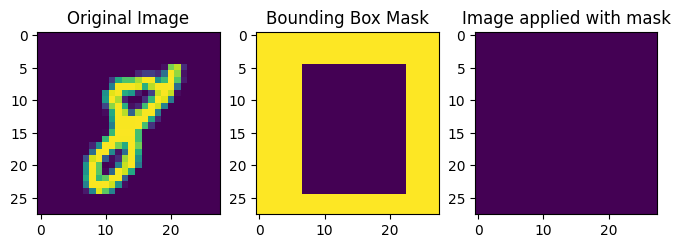

In [41]:
idx = 1
for i, (image, _, mask) in enumerate(rrr_ds_train):
    if i != idx:
        continue
    image = image.squeeze(0)
    mask = mask.squeeze(0)
    # Visualize the original image and the mask
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='viridis')

    plt.subplot(1, 3, 2)
    plt.title("Bounding Box Mask")
    plt.imshow(mask, cmap='viridis')
    
    plt.subplot(1, 3, 3)
    plt.title("Image applied with mask")
    plt.imshow(image * mask)

    plt.show()
    break  # Remove this break if you want to process more images

## 2.2 Model training

In [17]:
reset_parameters(model)

layer of type <class 'torch.nn.modules.activation.ReLU'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.pooling.MaxPool2d'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.activation.ReLU'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.pooling.MaxPool2d'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.flatten.Flatten'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.activation.ReLU'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.activation.Softmax'> does not have function `reset_parameters


In [19]:
from src.utils import XILUtils

In [24]:
import torch
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Flatten, Linear, Softmax

class CustomModel(Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.features = Sequential(
            # 1st group
            Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2, return_indices=True),
            # 2nd group
            Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        self.classifier = Sequential(
            Flatten(),
            Linear(in_features=32 * 7 * 7, out_features=128),  # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
            ReLU(),
            Linear(in_features=128, out_features=num_classes),
            Softmax(dim=1)
        )

    def forward(self, x):
        indices_list = []
        for layer in self.features:
            if isinstance(layer, MaxPool2d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)
        x = self.classifier(x)
        return x
    
    def __getitem__(self, idx):
        features_size = len(self.features)
        classifier_size = len(self.classifier)
        if idx < 0 or idx >= (features_size + classifier_size):
            raise RuntimeError(f"Index [{idx}] out of bounds")
        if idx < features_size:
            return self.features[idx]
        idx -= features_size
        return self.classifier[idx]

In [46]:
from src.utils import XILUtils
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from src.rrr_loss import RRRLoss

num_classes = 2
model = CustomModel(num_classes=num_classes)

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
sgd_opt = SGD(model.parameters(), lr=lr, momentum=0.9)
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
layers_of_interest = [model[0]]
loss = RRRLoss(model, layers_of_interest, rightreasons_lambda=2, device=device)

# create dataloader
rrr_train_dataloader = DataLoader(rrr_ds_train, batch_size=batch_size, shuffle=True)
rrr_test_dataloader = DataLoader(rrr_ds_test, batch_size=batch_size, shuffle=True)

epochs = 10

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")

    # train loop 
    print("training...")
    XILUtils.rrr_train_loop(model, rrr_train_dataloader, loss, adam_opt, batch_size, device)

    # Evaluate the model
    print("computing score...")
    XILUtils.rrr_test_loop(model, rrr_test_dataloader, loss, num_classes, device)

print("Done!")


Epoch 1
--------------------
training...
loss: 0.703022 [   64/  200]
loss: 0.703399 [  128/  200]
loss: 0.684968 [  192/  200]
loss: 0.681651 [  200/  200]
computing score...
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.675744 

Epoch 2
--------------------
training...
loss: 0.673914 [   64/  200]
loss: 0.668259 [  128/  200]
loss: 0.657231 [  192/  200]
loss: 0.628027 [  200/  200]
computing score...
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.673679 

Epoch 3
--------------------
training...
loss: 0.658800 [   64/  200]
loss: 0.658344 [  128/  200]
loss: 0.646684 [  192/  200]
loss: 0.590063 [  200/  200]
computing score...
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.635372 

Epoch 4
--------------------
training...
loss: 0.627669 [   64/  200]
loss: 0.635773 [  128/  200]
loss: 0.618560 [  192/  200]
loss: 0.586856 [  200/  200]
computing score...
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.629191 

Epoch 5
--------------------
training...
loss: 0.609455 [   64/  200]
loss: 0.620841 [  

In [21]:
print(len(model))

TypeError: object of type 'CustomModel' has no len()